# Convolutional Neural Network (CNN)

Erstmal nur einfache Unterscheidung in Roboter / Ball.

In [28]:
import os
import sys
import time
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import models, optimizers, losses, activations
from tensorflow.python.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array  

In [11]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 1.15.3
Num GPUs Available:  0


## Parameter

In [25]:
## Prepare Data

# force reload images from HUBOX
FORCE = False

# validation split
VALIDATION_SPLIT = 0.2

# folder path to image files (relatative)
IMAGE_FOLDER_NAME = 'images/robot_ball_dataset'

# image size
DIMEN = 240

# batch size ImageDataGenerator
BATCH_SIZE = 16


## Load Data

# path for npy files
DATA_FOLDER_PATH = 'images/processed_data'


## Prepare Tensorflow Parameter

NUMBER_OF_CLASSES = 2
EPOCHS = 10
DROPOUT_RATE = 0.25

MODEL_PATH = 'models/'

## Prepare Data

### Download Data from HU Box

In [4]:
# Download images files from HU Box

if FORCE or not os.path.exists("images"):
    print('TODO download files')
    # !./get_images.sh

### Process Images

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, 
    validation_split = VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'validation'
)

Found 9332 images belonging to 2 classes.
Found 2332 images belonging to 2 classes.


### Verify Data

TypeError: Invalid shape (16, 240, 240, 3) for image data

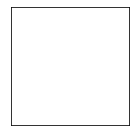

In [9]:
plt.figure(figsize=(20, 15))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_generator[i][0].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
    
plt.show()

## Prepare Tensorflow Parameter

## Create neural network

In [22]:
activation_func = activations.relu

NEURAL_SCHEMA = [

    Conv2D(32, (3, 3), activation=activation_func, input_shape=(240, 240, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation=activation_func),
    MaxPooling2D((2, 2)),

    Flatten(),
    
    Dense(100, activation=activation_func),
    Dropout(DROPOUT_RATE),

    Dense(NUMBER_OF_CLASSES, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(NEURAL_SCHEMA)

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Train Model

In [23]:
initial_time = time.time()

history = model.fit_generator(
    train_generator,
    #steps_per_epoch = train_generator.samples // 16,
    epochs = EPOCHS,
    validation_data = validation_generator, 
    #validation_steps = validation_generator.samples // 16,
)
    
final_time = time.time()
eta = (final_time - initial_time)
time_unit = 'seconds'
if eta >= 60:
    eta = eta / 60
    time_unit = 'minutes'
model.summary()
print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(EPOCHS, eta, time_unit))

model_path = os.path.join(MODEL_PATH, 'model-{}.h5'.format(datetime.fromtimestamp(final_time).strftime("%Y-%m-%d_%H-%M")))
model.save(model_path)

Epoch 1/10
187/187 [==============================] - 291s 2s/step - loss: 0.2209 - acc: 0.9534 - val_loss: 0.0063 - val_acc: 0.9974
Epoch 2/10
187/187 [==============================] - 285s 2s/step - loss: 0.0248 - acc: 0.9923 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 3/10
187/187 [==============================] - 289s 2s/step - loss: 0.0464 - acc: 0.9890 - val_loss: 0.7066 - val_acc: 0.7243
Epoch 4/10
187/187 [==============================] - 285s 2s/step - loss: 0.0435 - acc: 0.9861 - val_loss: 0.0110 - val_acc: 0.9979
Epoch 5/10
187/187 [==============================] - 283s 2s/step - loss: 0.0116 - acc: 0.9958 - val_loss: 0.0028 - val_acc: 0.9991
Epoch 6/10
187/187 [==============================] - 284s 2s/step - loss: 0.0161 - acc: 0.9941 - val_loss: 0.0012 - val_acc: 0.9991
Epoch 7/10
187/187 [==============================] - 279s 1s/step - loss: 0.0121 - acc: 0.9970 - val_loss: 9.3230e-04 - val_acc: 0.9991
Epoch 8/10
187/187 [==============================] - 280s 1s/ste

## Evaluate Model

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Predict